In [182]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

import tqdm as tqdm

import numpy as np
from scipy import stats
# Plots have dimension (w,h)
w = 3.5
h = 3.25 

import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# Loading

In [122]:
mc = np.load("../../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt = mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m = mc['sim_jets'][:, 3]
sim_w = mc['sim_widths']
sim_sdms = mc['sim_sdms']

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m, sim_w, sim_sdms]).T

dat = np.load("../../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]
dat_w = dat['sim_widths']
dat_sdms = dat['sim_sdms']

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m, dat_w, dat_sdms]).T

In [123]:
data = torch.tensor(sim, dtype = torch.float32)
dataset = DataLoader(data, batch_size = 2**6, shuffle = True)

In [174]:
r = np.load('../batch_losses.npy')

In [176]:
t = np.load('../total_losses.npy')

In [168]:
torch.save({
            'epoch': epoch,
            'model_state_dict': flow.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'ckpt')

In [169]:
cp = torch.load('ckpt')

In [170]:
num_layers = 5
base_dist = StandardNormal(shape=[6])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

In [ ]:
flow.load_state_dict(cp['model_state_dict'])

# Training

In [124]:
num_layers = 5
base_dist = StandardNormal(shape=[6])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [134]:
num_epochs = 100
losses = np.zeros(num_epochs * len(data))

i = 0
for epoch in tqdm.trange(num_epochs):
    for (batch_idx, batch) in enumerate(dataset):
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs = batch).mean()
        loss.backward()
        optimizer.step()
        
        losses[i] = loss
        if i % 100 == 0:
            print(i, '\t', round(losses[i], 2))
        i += 1

  0%|          | 0/100 [00:00<?, ?it/s]

0 	 24.74
100 	 24.7
200 	 24.96
300 	 27.02
400 	 24.48
500 	 24.42
600 	 24.44
700 	 24.53
800 	 23.98
900 	 24.62
1000 	 51.53
1100 	 25.11
1200 	 25.08
1300 	 24.03
1400 	 23.8
1500 	 24.54


  1%|          | 1/100 [00:15<25:20, 15.36s/it]

1600 	 24.59
1700 	 23.75
1800 	 34.34
1900 	 28.35
2000 	 24.89
2100 	 23.5
2200 	 24.35
2300 	 23.08
2400 	 23.73
2500 	 23.84
2600 	 22.92
2700 	 24.48
2800 	 23.25
2900 	 22.26
3000 	 23.04
3100 	 23.21


  2%|▏         | 2/100 [00:30<24:35, 15.05s/it]

3200 	 23.28
3300 	 22.71
3400 	 22.23
3500 	 23.59
3600 	 22.49
3700 	 22.56
3800 	 21.79
3900 	 23.63
4000 	 21.56
4100 	 21.91
4200 	 24.25
4300 	 21.69
4400 	 21.72
4500 	 21.81
4600 	 21.92


  3%|▎         | 3/100 [00:45<24:14, 15.00s/it]

4700 	 22.29
4800 	 21.18
4900 	 21.7
5000 	 20.34
5100 	 22.18
5200 	 23.04
5300 	 21.31
5400 	 21.66
5500 	 21.11
5600 	 20.65
5700 	 20.42
5800 	 20.33
5900 	 20.43
6000 	 20.28
6100 	 19.87
6200 	 20.32


  4%|▍         | 4/100 [00:59<23:54, 14.95s/it]

6300 	 20.01
6400 	 20.7
6500 	 20.94
6600 	 19.77
6700 	 19.48
6800 	 19.85
6900 	 20.17
7000 	 20.37
7100 	 19.35
7200 	 18.86
7300 	 20.01
7400 	 18.91
7500 	 19.01
7600 	 18.94
7700 	 18.53


  5%|▌         | 5/100 [01:14<23:32, 14.87s/it]

7800 	 19.26
7900 	 18.86
8000 	 19.86
8100 	 21.08
8200 	 18.47
8300 	 18.29
8400 	 19.5
8500 	 19.32
8600 	 18.97
8700 	 36.82
8800 	 18.68
8900 	 17.71
9000 	 19.58
9100 	 17.82
9200 	 18.7
9300 	 18.31


  6%|▌         | 6/100 [01:29<23:28, 14.98s/it]

9400 	 18.91
9500 	 18.27
9600 	 18.16
9700 	 17.36
9800 	 18.23
9900 	 17.65
10000 	 18.07
10100 	 17.56
10200 	 17.12
10300 	 18.02
10400 	 19.01
10500 	 19.64
10600 	 18.79
10700 	 22.53
10800 	 19.41
10900 	 20.13


  7%|▋         | 7/100 [01:44<23:14, 14.99s/it]

11000 	 18.75
11100 	 17.85
11200 	 18.47
11300 	 18.4
11400 	 17.92
11500 	 17.74
11600 	 18.08
11700 	 17.18
11800 	 17.49
11900 	 17.71
12000 	 17.54
12100 	 16.82
12200 	 16.85
12300 	 17.06
12400 	 17.16


  8%|▊         | 8/100 [02:00<23:06, 15.07s/it]

12500 	 16.84
12600 	 16.9
12700 	 16.96
12800 	 16.4
12900 	 17.41
13000 	 16.7
13100 	 16.42
13200 	 17.56
13300 	 15.74
13400 	 16.2
13500 	 16.04
13600 	 15.85
13700 	 16.26
13800 	 15.55
13900 	 15.54
14000 	 15.53


  9%|▉         | 9/100 [02:14<22:43, 14.99s/it]

14100 	 15.43
14200 	 14.99
14300 	 15.02
14400 	 15.86
14500 	 15.93
14600 	 15.08
14700 	 15.75
14800 	 14.98
14900 	 14.65
15000 	 14.67
15100 	 14.79
15200 	 14.94
15300 	 15.2
15400 	 14.28
15500 	 14.79
15600 	 14.55


 10%|█         | 10/100 [02:30<22:35, 15.06s/it]

15700 	 14.54
15800 	 14.62
15900 	 14.46
16000 	 14.47
16100 	 14.47
16200 	 14.54
16300 	 14.52
16400 	 14.54
16500 	 14.06
16600 	 14.38
16700 	 14.56
16800 	 15.69
16900 	 13.72
17000 	 14.2
17100 	 15.86


 11%|█         | 11/100 [02:45<22:15, 15.00s/it]

17200 	 14.52
17300 	 14.21
17400 	 14.41
17500 	 13.82
17600 	 14.61
17700 	 13.72
17800 	 17.33
17900 	 14.66
18000 	 14.68
18100 	 14.5
18200 	 14.98
18300 	 14.56
18400 	 13.96
18500 	 14.45
18600 	 13.51
18700 	 14.5


 12%|█▏        | 12/100 [03:00<22:06, 15.07s/it]

18800 	 14.5
18900 	 14.39
19000 	 14.31
19100 	 13.8
19200 	 14.82
19300 	 14.18
19400 	 13.42
19500 	 14.06
19600 	 14.46
19700 	 14.84
19800 	 14.01
19900 	 14.52
20000 	 13.43
20100 	 14.55
20200 	 14.49


 13%|█▎        | 13/100 [03:15<22:00, 15.18s/it]

20300 	 14.25
20400 	 14.03
20500 	 14.02
20600 	 13.68
20700 	 13.41
20800 	 13.76
20900 	 13.47
21000 	 13.19
21100 	 13.64
21200 	 13.55
21300 	 13.84
21400 	 13.2
21500 	 14.17
21600 	 14.3
21700 	 13.62
21800 	 14.08


 14%|█▍        | 14/100 [03:30<21:32, 15.02s/it]

21900 	 13.42
22000 	 13.61
22100 	 14.0
22200 	 13.21
22300 	 13.5
22400 	 12.87
22500 	 12.99
22600 	 13.69
22700 	 13.04
22800 	 13.3
22900 	 13.19
23000 	 13.56
23100 	 13.39
23200 	 13.23
23300 	 13.22
23400 	 13.44


 15%|█▌        | 15/100 [03:45<21:20, 15.06s/it]

23500 	 13.24
23600 	 13.25
23700 	 13.42
23800 	 13.5
23900 	 12.91
24000 	 13.24
24100 	 14.33
24200 	 13.47
24300 	 13.34
24400 	 13.04
24500 	 13.61
24600 	 13.68
24700 	 13.03
24800 	 13.04
24900 	 13.27


 16%|█▌        | 16/100 [04:00<21:05, 15.07s/it]

25000 	 13.12
25100 	 13.3
25200 	 13.35
25300 	 13.28
25400 	 13.29
25500 	 13.2
25600 	 14.15
25700 	 13.32
25800 	 13.2
25900 	 13.15
26000 	 12.91
26100 	 13.24
26200 	 12.76
26300 	 13.15
26400 	 12.96
26500 	 13.57


 17%|█▋        | 17/100 [04:16<20:58, 15.17s/it]

26600 	 13.62
26700 	 13.24
26800 	 13.45
26900 	 13.23
27000 	 13.08
27100 	 13.93
27200 	 12.82
27300 	 13.24
27400 	 13.23
27500 	 12.56
27600 	 13.38
27700 	 13.22
27800 	 12.66
27900 	 13.16
28000 	 12.99
28100 	 12.67


 18%|█▊        | 18/100 [04:31<20:51, 15.26s/it]

28200 	 12.97
28300 	 13.37
28400 	 13.13
28500 	 12.7
28600 	 12.92
28700 	 12.95
28800 	 13.05
28900 	 12.73
29000 	 13.09
29100 	 12.68
29200 	 12.84
29300 	 13.76
29400 	 12.95
29500 	 13.08
29600 	 12.84


 19%|█▉        | 19/100 [04:46<20:33, 15.23s/it]

29700 	 12.96
29800 	 12.69
29900 	 12.96
30000 	 12.71
30100 	 14.02
30200 	 12.82
30300 	 12.9
30400 	 13.0
30500 	 13.93
30600 	 13.09
30700 	 13.01
30800 	 13.18
30900 	 13.63
31000 	 12.51
31100 	 12.83
31200 	 13.05


 20%|██        | 20/100 [05:02<20:22, 15.28s/it]

31300 	 12.92
31400 	 13.4
31500 	 12.89
31600 	 13.11
31700 	 13.28
31800 	 12.91
31900 	 12.88
32000 	 13.02
32100 	 13.23
32200 	 13.04
32300 	 13.27
32400 	 13.46
32500 	 13.24
32600 	 12.47
32700 	 12.8
32800 	 12.7


 21%|██        | 21/100 [05:16<19:54, 15.12s/it]

32900 	 12.77
33000 	 13.29
33100 	 13.25
33200 	 13.22
33300 	 13.6
33400 	 13.11
33500 	 13.35
33600 	 12.8
33700 	 12.91
33800 	 12.38
33900 	 13.05
34000 	 13.22
34100 	 13.26
34200 	 13.23
34300 	 12.37


 22%|██▏       | 22/100 [05:31<19:28, 14.98s/it]

34400 	 13.45
34500 	 13.11
34600 	 13.39
34700 	 13.06
34800 	 13.19
34900 	 12.97
35000 	 13.3
35100 	 12.73
35200 	 13.63
35300 	 13.42
35400 	 13.0
35500 	 12.86
35600 	 12.97
35700 	 12.83
35800 	 13.43
35900 	 12.85


 23%|██▎       | 23/100 [05:46<19:17, 15.03s/it]

36000 	 12.76
36100 	 12.79
36200 	 13.03
36300 	 12.92
36400 	 13.13
36500 	 12.85
36600 	 12.85
36700 	 13.05
36800 	 12.83
36900 	 13.03
37000 	 12.89
37100 	 12.87
37200 	 12.2
37300 	 12.93
37400 	 13.06


 24%|██▍       | 24/100 [06:01<19:09, 15.13s/it]

37500 	 13.43
37600 	 12.7
37700 	 13.08
37800 	 12.97
37900 	 12.73
38000 	 13.3
38100 	 13.2
38200 	 12.39
38300 	 13.32
38400 	 13.0
38500 	 13.07
38600 	 12.77
38700 	 12.17
38800 	 13.33
38900 	 12.8
39000 	 12.4


 25%|██▌       | 25/100 [06:17<18:56, 15.16s/it]

39100 	 12.78
39200 	 13.68
39300 	 13.22
39400 	 12.92
39500 	 13.0
39600 	 13.06
39700 	 12.51
39800 	 12.54
39900 	 12.92
40000 	 12.87
40100 	 12.7
40200 	 13.34
40300 	 12.5
40400 	 13.07
40500 	 12.45
40600 	 12.86


 26%|██▌       | 26/100 [06:32<18:35, 15.07s/it]

40700 	 12.4
40800 	 12.58
40900 	 12.75
41000 	 12.75
41100 	 12.57
41200 	 12.62
41300 	 12.53
41400 	 13.09
41500 	 13.0
41600 	 12.9
41700 	 12.81
41800 	 13.06
41900 	 13.12
42000 	 12.81
42100 	 12.67


 27%|██▋       | 27/100 [06:47<18:29, 15.20s/it]

42200 	 13.38
42300 	 12.88
42400 	 12.56
42500 	 12.78
42600 	 12.89
42700 	 13.34
42800 	 12.98
42900 	 13.3
43000 	 12.58
43100 	 13.62
43200 	 12.85
43300 	 12.79
43400 	 12.86
43500 	 12.9
43600 	 12.31
43700 	 13.45


 28%|██▊       | 28/100 [07:03<18:31, 15.44s/it]

43800 	 12.86
43900 	 12.59
44000 	 12.62
44100 	 12.97
44200 	 12.67
44300 	 12.42
44400 	 13.25
44500 	 13.17
44600 	 12.76
44700 	 13.05
44800 	 12.85
44900 	 12.61
45000 	 12.55
45100 	 12.57
45200 	 12.88
45300 	 12.62


 29%|██▉       | 29/100 [07:18<18:12, 15.39s/it]

45400 	 13.22
45500 	 12.81
45600 	 12.95
45700 	 12.59
45800 	 12.99
45900 	 12.63
46000 	 13.48
46100 	 12.62
46200 	 13.29
46300 	 12.47
46400 	 12.93
46500 	 13.03
46600 	 13.15
46700 	 12.86
46800 	 13.16


 30%|███       | 30/100 [07:34<18:12, 15.60s/it]

46900 	 12.5
47000 	 12.64
47100 	 12.48
47200 	 12.87
47300 	 12.64
47400 	 13.1
47500 	 12.7
47600 	 12.74
47700 	 12.58
47800 	 12.69
47900 	 12.72
48000 	 12.94
48100 	 12.37
48200 	 13.0
48300 	 12.61
48400 	 12.95


 31%|███       | 31/100 [07:50<17:51, 15.53s/it]

48500 	 12.06
48600 	 12.86
48700 	 13.62
48800 	 12.25
48900 	 12.6
49000 	 12.52
49100 	 13.06
49200 	 12.78
49300 	 12.73
49400 	 12.56
49500 	 12.51
49600 	 12.7
49700 	 13.19
49800 	 12.36
49900 	 12.7


 32%|███▏      | 32/100 [08:05<17:30, 15.45s/it]

50000 	 12.57
50100 	 12.43
50200 	 12.82
50300 	 13.1
50400 	 12.56
50500 	 12.86
50600 	 12.84
50700 	 13.17
50800 	 12.57
50900 	 12.92
51000 	 13.0
51100 	 12.46
51200 	 12.88
51300 	 12.42
51400 	 12.81
51500 	 12.4


 33%|███▎      | 33/100 [08:20<17:04, 15.29s/it]

51600 	 12.31
51700 	 12.73
51800 	 12.78
51900 	 13.17
52000 	 12.82
52100 	 13.1
52200 	 12.34
52300 	 12.34
52400 	 12.39
52500 	 12.48
52600 	 12.94
52700 	 12.43
52800 	 12.79
52900 	 12.58
53000 	 12.94
53100 	 12.61


 34%|███▍      | 34/100 [08:35<16:35, 15.09s/it]

53200 	 12.57
53300 	 12.4
53400 	 12.38
53500 	 12.44
53600 	 12.88
53700 	 12.98
53800 	 12.88
53900 	 12.5
54000 	 12.66
54100 	 13.13
54200 	 12.96
54300 	 12.71
54400 	 12.7
54500 	 12.79
54600 	 12.71


 35%|███▌      | 35/100 [08:50<16:31, 15.26s/it]

54700 	 12.93
54800 	 12.54
54900 	 12.48
55000 	 12.41
55100 	 12.65
55200 	 12.5
55300 	 12.59
55400 	 12.93
55500 	 12.47
55600 	 12.51
55700 	 12.71
55800 	 12.54
55900 	 12.59
56000 	 13.11
56100 	 12.97
56200 	 12.94


 36%|███▌      | 36/100 [09:06<16:25, 15.39s/it]

56300 	 12.44
56400 	 12.4
56500 	 12.22
56600 	 12.71
56700 	 13.12
56800 	 13.03
56900 	 12.6
57000 	 13.12
57100 	 12.87
57200 	 12.79
57300 	 12.5
57400 	 12.18
57500 	 12.55
57600 	 12.61
57700 	 12.24
57800 	 12.39


 37%|███▋      | 37/100 [09:21<15:59, 15.22s/it]

57900 	 12.31
58000 	 12.53
58100 	 12.45
58200 	 12.92
58300 	 12.62
58400 	 12.56
58500 	 13.22
58600 	 12.53
58700 	 12.7
58800 	 12.86
58900 	 13.29
59000 	 13.17
59100 	 12.62
59200 	 12.76
59300 	 12.63


 38%|███▊      | 38/100 [09:36<15:35, 15.09s/it]

59400 	 12.86
59500 	 12.35
59600 	 13.07
59700 	 12.64
59800 	 12.61
59900 	 12.48
60000 	 12.54
60100 	 13.22
60200 	 12.99
60300 	 12.98
60400 	 12.34
60500 	 12.53
60600 	 12.59
60700 	 12.74
60800 	 12.53
60900 	 12.57


 39%|███▉      | 39/100 [09:51<15:18, 15.06s/it]

61000 	 12.55
61100 	 12.88
61200 	 12.64
61300 	 12.97
61400 	 12.3
61500 	 12.14
61600 	 12.97
61700 	 12.66
61800 	 13.06
61900 	 12.43
62000 	 12.89
62100 	 12.86
62200 	 12.54
62300 	 12.43
62400 	 13.07


 40%|████      | 40/100 [10:07<15:19, 15.33s/it]

62500 	 12.63
62600 	 12.6
62700 	 12.74
62800 	 12.75
62900 	 12.23
63000 	 12.13
63100 	 12.42
63200 	 12.43
63300 	 12.47
63400 	 12.12
63500 	 12.49
63600 	 12.57
63700 	 12.69
63800 	 12.52
63900 	 13.2
64000 	 13.09


 41%|████      | 41/100 [10:22<15:00, 15.27s/it]

64100 	 12.54
64200 	 12.44
64300 	 12.53
64400 	 12.75
64500 	 12.32
64600 	 12.51
64700 	 12.57
64800 	 12.3
64900 	 12.58
65000 	 12.55
65100 	 12.86
65200 	 13.09
65300 	 12.96
65400 	 12.42
65500 	 13.29
65600 	 12.78


 42%|████▏     | 42/100 [10:38<14:58, 15.50s/it]

65700 	 12.86
65800 	 12.91
65900 	 12.57
66000 	 12.35
66100 	 12.45
66200 	 13.51
66300 	 12.53
66400 	 12.41
66500 	 12.79
66600 	 12.83
66700 	 12.15
66800 	 12.71
66900 	 12.37
67000 	 12.31
67100 	 12.38


 43%|████▎     | 43/100 [10:54<14:54, 15.69s/it]

67200 	 12.83
67300 	 13.06
67400 	 12.54
67500 	 12.55
67600 	 12.54
67700 	 12.56
67800 	 13.03
67900 	 12.43
68000 	 13.18
68100 	 12.51
68200 	 12.72
68300 	 12.28
68400 	 12.7
68500 	 12.83
68600 	 12.52
68700 	 12.42


 44%|████▍     | 44/100 [11:10<14:46, 15.82s/it]

68800 	 13.08
68900 	 12.34
69000 	 12.79
69100 	 12.52
69200 	 12.4
69300 	 12.39
69400 	 12.5
69500 	 12.41
69600 	 12.66
69700 	 12.75
69800 	 12.99
69900 	 12.69
70000 	 12.66
70100 	 12.24
70200 	 13.24
70300 	 12.59


 45%|████▌     | 45/100 [11:26<14:33, 15.88s/it]

70400 	 12.7
70500 	 12.64
70600 	 12.78
70700 	 13.1
70800 	 12.59
70900 	 12.8
71000 	 12.73
71100 	 12.73
71200 	 12.24
71300 	 12.21
71400 	 12.93
71500 	 12.71
71600 	 12.62
71700 	 12.63
71800 	 12.07


 46%|████▌     | 46/100 [11:41<14:04, 15.63s/it]

71900 	 12.31
72000 	 12.51
72100 	 12.28
72200 	 11.93
72300 	 12.66
72400 	 12.65
72500 	 12.13
72600 	 12.66
72700 	 12.74
72800 	 12.23
72900 	 12.26
73000 	 12.41
73100 	 12.44
73200 	 12.08
73300 	 12.45
73400 	 12.68


 47%|████▋     | 47/100 [11:56<13:41, 15.49s/it]

73500 	 12.89
73600 	 12.3
73700 	 12.37
73800 	 12.97
73900 	 12.22
74000 	 12.25
74100 	 12.42
74200 	 12.78
74300 	 12.54
74400 	 12.42
74500 	 13.03
74600 	 13.13
74700 	 12.38
74800 	 12.54
74900 	 12.39
75000 	 12.61


 48%|████▊     | 48/100 [12:12<13:37, 15.72s/it]

75100 	 12.72
75200 	 12.25
75300 	 12.75
75400 	 12.97
75500 	 11.96
75600 	 12.47
75700 	 12.88
75800 	 12.5
75900 	 12.75
76000 	 12.7
76100 	 12.74
76200 	 12.54
76300 	 12.59
76400 	 12.73
76500 	 12.55


 49%|████▉     | 49/100 [12:28<13:16, 15.61s/it]

76600 	 12.37
76700 	 12.92
76800 	 12.68
76900 	 12.38
77000 	 12.88
77100 	 12.88
77200 	 12.33
77300 	 12.62
77400 	 12.84
77500 	 12.27
77600 	 12.35
77700 	 12.65
77800 	 11.97
77900 	 12.41
78000 	 12.81
78100 	 13.05


 50%|█████     | 50/100 [12:43<13:01, 15.63s/it]

78200 	 12.33
78300 	 12.43
78400 	 12.39
78500 	 12.72
78600 	 12.52
78700 	 12.8
78800 	 12.61
78900 	 12.28
79000 	 12.74
79100 	 12.85
79200 	 12.25
79300 	 12.6
79400 	 12.51
79500 	 12.86
79600 	 12.46


 51%|█████     | 51/100 [12:59<12:48, 15.68s/it]

79700 	 12.25
79800 	 12.25
79900 	 12.49
80000 	 13.17
80100 	 12.69
80200 	 12.69
80300 	 12.7
80400 	 12.31
80500 	 12.28
80600 	 12.73
80700 	 12.47
80800 	 12.68
80900 	 12.49
81000 	 12.55
81100 	 12.85
81200 	 13.0


 52%|█████▏    | 52/100 [13:15<12:30, 15.63s/it]

81300 	 12.57
81400 	 12.41
81500 	 12.67
81600 	 12.38
81700 	 12.45
81800 	 12.89
81900 	 12.63
82000 	 12.42
82100 	 12.52
82200 	 12.72
82300 	 12.89
82400 	 12.4
82500 	 12.84
82600 	 12.37
82700 	 12.26
82800 	 12.64


 53%|█████▎    | 53/100 [13:32<12:29, 15.96s/it]

82900 	 12.2
83000 	 12.33
83100 	 12.1
83200 	 13.09
83300 	 12.6
83400 	 12.61
83500 	 12.78
83600 	 12.68
83700 	 12.65
83800 	 12.54
83900 	 12.48
84000 	 12.19
84100 	 12.61
84200 	 12.11
84300 	 12.79


 54%|█████▍    | 54/100 [13:49<12:34, 16.41s/it]

84400 	 12.04
84500 	 12.37
84600 	 12.43
84700 	 12.35
84800 	 13.01
84900 	 12.67
85000 	 12.89
85100 	 12.99
85200 	 12.78
85300 	 12.09
85400 	 12.85
85500 	 12.57
85600 	 12.33
85700 	 12.9
85800 	 12.8
85900 	 13.04


 55%|█████▌    | 55/100 [14:05<12:13, 16.29s/it]

86000 	 12.84
86100 	 12.26
86200 	 12.51
86300 	 12.18
86400 	 13.14
86500 	 12.68
86600 	 12.94
86700 	 12.34
86800 	 12.51
86900 	 12.38
87000 	 12.6
87100 	 12.43
87200 	 12.72
87300 	 12.4
87400 	 12.66
87500 	 12.98


 56%|█████▌    | 56/100 [14:20<11:45, 16.04s/it]

87600 	 12.38
87700 	 12.36
87800 	 12.38
87900 	 12.84
88000 	 12.69
88100 	 12.32
88200 	 12.35
88300 	 12.68
88400 	 12.4
88500 	 12.85
88600 	 12.53
88700 	 12.37
88800 	 12.57
88900 	 12.86
89000 	 12.4


 57%|█████▋    | 57/100 [14:36<11:24, 15.93s/it]

89100 	 12.16
89200 	 12.67
89300 	 12.7
89400 	 12.23
89500 	 12.95
89600 	 12.42
89700 	 12.91
89800 	 12.41
89900 	 12.48
90000 	 12.89
90100 	 13.01
90200 	 12.89
90300 	 12.26
90400 	 12.23
90500 	 12.42
90600 	 12.7


 58%|█████▊    | 58/100 [14:53<11:18, 16.15s/it]

90700 	 12.51
90800 	 12.8
90900 	 12.78
91000 	 12.78
91100 	 12.46
91200 	 12.66
91300 	 12.4
91400 	 13.12
91500 	 12.54
91600 	 12.82
91700 	 12.46
91800 	 12.28
91900 	 12.47
92000 	 12.67
92100 	 12.36


 59%|█████▉    | 59/100 [15:08<10:56, 16.01s/it]

92200 	 12.7
92300 	 12.84
92400 	 12.77
92500 	 11.98
92600 	 12.03
92700 	 12.56
92800 	 12.65
92900 	 12.29
93000 	 12.22
93100 	 12.54
93200 	 12.65
93300 	 12.48
93400 	 12.48
93500 	 13.07
93600 	 12.76
93700 	 12.5


 60%|██████    | 60/100 [15:25<10:51, 16.28s/it]

93800 	 12.44
93900 	 12.79
94000 	 12.09
94100 	 12.63
94200 	 12.35
94300 	 12.6
94400 	 12.75
94500 	 12.68
94600 	 12.3
94700 	 12.44
94800 	 12.84
94900 	 12.66
95000 	 12.81
95100 	 12.5
95200 	 12.7
95300 	 12.04


 61%|██████    | 61/100 [15:43<10:48, 16.63s/it]

95400 	 12.87
95500 	 12.43
95600 	 12.67
95700 	 12.76
95800 	 12.22
95900 	 12.59
96000 	 13.03
96100 	 12.65
96200 	 12.52
96300 	 12.3
96400 	 12.74
96500 	 11.95
96600 	 12.22
96700 	 12.46
96800 	 12.36


 62%|██████▏   | 62/100 [15:58<10:19, 16.30s/it]

96900 	 12.75
97000 	 12.55
97100 	 12.83
97200 	 12.19
97300 	 12.67
97400 	 12.43
97500 	 12.71
97600 	 12.76
97700 	 12.64
97800 	 12.3
97900 	 12.84
98000 	 12.45
98100 	 12.69
98200 	 12.53
98300 	 12.26
98400 	 12.28


 63%|██████▎   | 63/100 [16:15<10:01, 16.27s/it]

98500 	 12.63
98600 	 12.5
98700 	 12.36
98800 	 12.28
98900 	 12.61
99000 	 12.01
99100 	 12.12
99200 	 12.59
99300 	 12.63
99400 	 12.79
99500 	 12.29
99600 	 12.33
99700 	 12.41
99800 	 12.27
99900 	 12.39
100000 	 12.12


 64%|██████▍   | 64/100 [16:30<09:40, 16.14s/it]

100100 	 12.14
100200 	 12.6
100300 	 12.44
100400 	 12.28
100500 	 12.33
100600 	 12.42
100700 	 12.67
100800 	 12.82
100900 	 12.46
101000 	 12.85
101100 	 12.3
101200 	 12.31
101300 	 12.91
101400 	 12.71
101500 	 12.5


 65%|██████▌   | 65/100 [16:47<09:26, 16.19s/it]

101600 	 12.35
101700 	 12.64
101800 	 11.98
101900 	 12.67
102000 	 12.42
102100 	 12.97
102200 	 12.19
102300 	 12.63
102400 	 12.55
102500 	 12.38
102600 	 12.71
102700 	 11.89
102800 	 12.56
102900 	 12.07
103000 	 12.54
103100 	 12.61


 66%|██████▌   | 66/100 [17:03<09:08, 16.14s/it]

103200 	 12.53
103300 	 12.47
103400 	 12.47
103500 	 12.79
103600 	 12.49
103700 	 12.83
103800 	 12.83
103900 	 12.71
104000 	 12.62
104100 	 12.28
104200 	 12.28
104300 	 12.56
104400 	 12.74
104500 	 12.25
104600 	 12.62


 67%|██████▋   | 67/100 [17:19<08:51, 16.09s/it]

104700 	 12.56
104800 	 12.44
104900 	 12.29
105000 	 12.45
105100 	 12.73
105200 	 12.19
105300 	 12.93
105400 	 12.6
105500 	 12.92
105600 	 12.14
105700 	 12.76
105800 	 12.32
105900 	 12.55
106000 	 12.39
106100 	 11.78
106200 	 12.74


 68%|██████▊   | 68/100 [17:34<08:31, 15.99s/it]

106300 	 12.69
106400 	 12.34
106500 	 12.32
106600 	 12.43
106700 	 12.71
106800 	 12.57
106900 	 12.2
107000 	 12.39
107100 	 12.24
107200 	 12.52
107300 	 12.33
107400 	 12.81
107500 	 12.28
107600 	 12.51
107700 	 12.39
107800 	 12.65


 69%|██████▉   | 69/100 [17:50<08:10, 15.84s/it]

107900 	 12.45
108000 	 12.16
108100 	 12.54
108200 	 12.44
108300 	 13.04
108400 	 12.36
108500 	 13.0
108600 	 12.55
108700 	 12.76
108800 	 12.78
108900 	 12.06
109000 	 12.88
109100 	 12.54
109200 	 12.44
109300 	 12.61


 70%|███████   | 70/100 [18:06<08:00, 16.03s/it]

109400 	 12.97
109500 	 12.58
109600 	 12.66
109700 	 12.1
109800 	 12.32
109900 	 12.48
110000 	 12.23
110100 	 12.52
110200 	 12.93
110300 	 13.04
110400 	 12.41
110500 	 12.26
110600 	 12.04
110700 	 12.85
110800 	 12.43
110900 	 12.53


 71%|███████   | 71/100 [18:22<07:44, 16.02s/it]

111000 	 12.2
111100 	 12.64
111200 	 12.57
111300 	 12.68
111400 	 12.3
111500 	 13.07
111600 	 12.47
111700 	 12.35
111800 	 12.77
111900 	 12.29
112000 	 12.35
112100 	 12.39
112200 	 12.23
112300 	 12.58
112400 	 12.45
112500 	 12.51


 72%|███████▏  | 72/100 [18:38<07:26, 15.93s/it]

112600 	 12.75
112700 	 12.35
112800 	 12.72
112900 	 12.61
113000 	 12.64
113100 	 12.62
113200 	 12.34
113300 	 12.74
113400 	 12.61
113500 	 12.42
113600 	 12.26
113700 	 12.55
113800 	 12.61
113900 	 12.98
114000 	 12.54


 73%|███████▎  | 73/100 [18:54<07:11, 16.00s/it]

114100 	 13.35
114200 	 12.61
114300 	 12.43
114400 	 12.68
114500 	 12.14
114600 	 12.57
114700 	 12.05
114800 	 12.46
114900 	 12.27
115000 	 12.59
115100 	 12.22
115200 	 12.69
115300 	 11.98
115400 	 12.79
115500 	 12.44
115600 	 12.52


 74%|███████▍  | 74/100 [19:10<06:55, 15.97s/it]

115700 	 12.24
115800 	 12.2
115900 	 12.72
116000 	 12.92
116100 	 12.72
116200 	 12.41
116300 	 12.09
116400 	 12.33
116500 	 12.88
116600 	 12.62
116700 	 12.59
116800 	 12.33
116900 	 12.15
117000 	 12.71
117100 	 12.21
117200 	 12.5


 75%|███████▌  | 75/100 [19:26<06:38, 15.92s/it]

117300 	 12.69
117400 	 12.65
117500 	 12.46
117600 	 11.97
117700 	 12.31
117800 	 12.51
117900 	 12.54
118000 	 12.06
118100 	 12.85
118200 	 13.33
118300 	 12.14
118400 	 12.3
118500 	 12.7
118600 	 12.79
118700 	 12.56


 76%|███████▌  | 76/100 [19:42<06:20, 15.86s/it]

118800 	 12.55
118900 	 12.31
119000 	 13.25
119100 	 13.02
119200 	 13.23
119300 	 12.42
119400 	 12.82
119500 	 12.25
119600 	 12.31
119700 	 12.55
119800 	 12.59
119900 	 12.58
120000 	 12.88
120100 	 12.84
120200 	 12.27
120300 	 12.63


 77%|███████▋  | 77/100 [19:58<06:05, 15.89s/it]

120400 	 12.78
120500 	 12.14
120600 	 12.45
120700 	 12.58
120800 	 12.64
120900 	 12.66
121000 	 12.54
121100 	 12.05
121200 	 12.39
121300 	 12.26
121400 	 12.74
121500 	 12.46
121600 	 12.44
121700 	 12.46
121800 	 12.83


 78%|███████▊  | 78/100 [20:14<05:50, 15.93s/it]

121900 	 12.2
122000 	 12.42
122100 	 12.65
122200 	 12.39
122300 	 12.17
122400 	 12.27
122500 	 12.55
122600 	 12.6
122700 	 12.71
122800 	 12.72
122900 	 12.3
123000 	 12.47
123100 	 12.44
123200 	 12.3
123300 	 12.45
123400 	 12.31


 79%|███████▉  | 79/100 [20:30<05:34, 15.91s/it]

123500 	 12.42
123600 	 12.45
123700 	 12.6
123800 	 12.37
123900 	 12.28
124000 	 12.45
124100 	 12.21
124200 	 12.49
124300 	 11.88
124400 	 12.22
124500 	 12.27
124600 	 12.64
124700 	 12.82
124800 	 12.58
124900 	 12.48
125000 	 12.26


 80%|████████  | 80/100 [20:45<05:14, 15.72s/it]

125100 	 12.88
125200 	 12.46
125300 	 12.49
125400 	 12.41
125500 	 12.41
125600 	 12.3
125700 	 12.5
125800 	 12.46
125900 	 12.38
126000 	 12.9
126100 	 12.84
126200 	 12.67
126300 	 12.52
126400 	 12.53
126500 	 12.61


 81%|████████  | 81/100 [21:01<04:59, 15.77s/it]

126600 	 12.47
126700 	 12.3
126800 	 12.6
126900 	 12.54
127000 	 12.96
127100 	 12.54
127200 	 12.7
127300 	 12.43
127400 	 12.6
127500 	 12.32
127600 	 12.73
127700 	 12.52
127800 	 12.17
127900 	 12.78
128000 	 12.11
128100 	 12.78


 82%|████████▏ | 82/100 [21:17<04:48, 16.01s/it]

128200 	 12.68
128300 	 12.71
128400 	 13.49
128500 	 12.36
128600 	 12.51
128700 	 12.94
128800 	 12.88
128900 	 12.85
129000 	 12.57
129100 	 12.2
129200 	 13.01
129300 	 12.45
129400 	 12.68
129500 	 12.47
129600 	 12.61
129700 	 12.65


 83%|████████▎ | 83/100 [21:33<04:29, 15.82s/it]

129800 	 12.77
129900 	 12.74
130000 	 12.56
130100 	 12.27
130200 	 12.51
130300 	 12.57
130400 	 12.63
130500 	 12.64
130600 	 12.28
130700 	 12.35
130800 	 12.68
130900 	 12.5
131000 	 12.25
131100 	 12.64
131200 	 12.62


 84%|████████▍ | 84/100 [21:49<04:17, 16.12s/it]

131300 	 12.67
131400 	 12.62
131500 	 12.54
131600 	 12.48
131700 	 12.64
131800 	 12.23
131900 	 12.68
132000 	 12.4
132100 	 12.14
132200 	 12.3
132300 	 12.6
132400 	 12.63
132500 	 12.6
132600 	 12.35
132700 	 12.69
132800 	 12.63


 85%|████████▌ | 85/100 [22:06<04:02, 16.14s/it]

132900 	 12.96
133000 	 12.38
133100 	 12.42
133200 	 12.55
133300 	 12.44
133400 	 11.93
133500 	 12.34
133600 	 12.9
133700 	 12.43
133800 	 12.57
133900 	 12.79
134000 	 12.26
134100 	 12.47
134200 	 12.7
134300 	 12.07
134400 	 12.49


 86%|████████▌ | 86/100 [22:22<03:46, 16.20s/it]

134500 	 12.21
134600 	 12.59
134700 	 12.69
134800 	 12.35
134900 	 12.65
135000 	 12.73
135100 	 12.84
135200 	 12.53
135300 	 12.42
135400 	 12.75
135500 	 12.47
135600 	 12.6
135700 	 12.54
135800 	 12.53
135900 	 12.92


 87%|████████▋ | 87/100 [22:38<03:30, 16.22s/it]

136000 	 13.06
136100 	 12.44
136200 	 12.65
136300 	 12.27
136400 	 12.47
136500 	 12.59
136600 	 12.38
136700 	 12.0
136800 	 12.64
136900 	 12.26
137000 	 12.54
137100 	 12.51
137200 	 12.14
137300 	 12.35
137400 	 12.49
137500 	 12.93


 88%|████████▊ | 88/100 [22:54<03:13, 16.16s/it]

137600 	 12.59
137700 	 12.91
137800 	 12.41
137900 	 13.05
138000 	 12.62
138100 	 12.82
138200 	 12.54
138300 	 12.15
138400 	 12.59
138500 	 12.38
138600 	 12.43
138700 	 12.63
138800 	 12.38
138900 	 12.48
139000 	 12.27


 89%|████████▉ | 89/100 [23:10<02:56, 16.08s/it]

139100 	 12.3
139200 	 12.61
139300 	 12.64
139400 	 12.46
139500 	 12.65
139600 	 12.69
139700 	 12.51
139800 	 12.52
139900 	 12.86
140000 	 12.89
140100 	 12.36
140200 	 12.68
140300 	 12.3
140400 	 12.44
140500 	 12.43
140600 	 12.7


 90%|█████████ | 90/100 [23:26<02:41, 16.12s/it]

140700 	 12.37
140800 	 12.68
140900 	 12.2
141000 	 12.62
141100 	 12.23
141200 	 12.49
141300 	 12.56
141400 	 12.52
141500 	 12.66
141600 	 12.93
141700 	 12.34
141800 	 12.4
141900 	 12.48
142000 	 12.64
142100 	 11.91
142200 	 12.82


 91%|█████████ | 91/100 [23:43<02:25, 16.12s/it]

142300 	 12.82
142400 	 11.92
142500 	 12.07
142600 	 12.66
142700 	 12.28
142800 	 12.65
142900 	 12.65
143000 	 12.11
143100 	 12.75
143200 	 12.5
143300 	 12.52
143400 	 12.5
143500 	 12.06
143600 	 12.54
143700 	 12.52


 92%|█████████▏| 92/100 [23:58<02:07, 15.97s/it]

143800 	 12.83
143900 	 12.59
144000 	 12.27
144100 	 13.25
144200 	 12.28
144300 	 12.66
144400 	 12.51
144500 	 12.79
144600 	 12.54
144700 	 12.32
144800 	 12.51
144900 	 12.38
145000 	 12.16
145100 	 12.43
145200 	 12.05
145300 	 12.47


 93%|█████████▎| 93/100 [24:15<01:53, 16.26s/it]

145400 	 12.72
145500 	 12.28
145600 	 12.15
145700 	 12.57
145800 	 12.51
145900 	 12.76
146000 	 12.6
146100 	 12.65
146200 	 12.45
146300 	 12.63
146400 	 12.63
146500 	 12.32
146600 	 12.49
146700 	 12.32
146800 	 12.53
146900 	 12.31


 94%|█████████▍| 94/100 [24:31<01:37, 16.22s/it]

147000 	 11.88
147100 	 12.75
147200 	 12.39
147300 	 12.46
147400 	 12.61
147500 	 12.56
147600 	 12.79
147700 	 12.6
147800 	 12.48
147900 	 12.7
148000 	 12.74
148100 	 12.61
148200 	 12.63
148300 	 12.35
148400 	 12.85


 95%|█████████▌| 95/100 [24:47<01:19, 15.97s/it]

148500 	 12.89
148600 	 12.66
148700 	 12.34
148800 	 12.17
148900 	 12.61
149000 	 12.71
149100 	 12.62
149200 	 12.58
149300 	 12.75
149400 	 12.26
149500 	 12.44
149600 	 12.75
149700 	 12.52
149800 	 12.43
149900 	 12.57
150000 	 12.29


 96%|█████████▌| 96/100 [25:02<01:03, 15.84s/it]

150100 	 12.65
150200 	 12.36
150300 	 11.95
150400 	 12.37
150500 	 12.32
150600 	 12.33
150700 	 12.31
150800 	 12.47
150900 	 12.66
151000 	 12.56
151100 	 12.45
151200 	 12.28
151300 	 12.93
151400 	 12.23
151500 	 12.21


 97%|█████████▋| 97/100 [25:18<00:47, 15.93s/it]

151600 	 12.64
151700 	 12.69
151800 	 12.25
151900 	 12.39
152000 	 12.89
152100 	 12.58
152200 	 11.82
152300 	 12.19
152400 	 12.56
152500 	 12.28
152600 	 12.53
152700 	 12.18
152800 	 12.73
152900 	 12.3
153000 	 12.2
153100 	 12.11


 98%|█████████▊| 98/100 [25:35<00:32, 16.18s/it]

153200 	 12.04
153300 	 12.4
153400 	 12.75
153500 	 12.38
153600 	 12.69
153700 	 12.44
153800 	 12.64
153900 	 12.45
154000 	 11.95
154100 	 12.55
154200 	 12.37
154300 	 12.29
154400 	 12.77
154500 	 12.16
154600 	 12.48
154700 	 12.55


 99%|█████████▉| 99/100 [25:51<00:16, 16.14s/it]

154800 	 13.07
154900 	 12.45
155000 	 12.17
155100 	 12.33
155200 	 12.48
155300 	 12.5
155400 	 12.14
155500 	 12.76
155600 	 12.41
155700 	 12.78
155800 	 12.46
155900 	 12.49
156000 	 12.44
156100 	 11.87
156200 	 12.32


100%|██████████| 100/100 [26:07<00:00, 15.68s/it]


In [5]:
num_iter = 5000
losses = np.zeros(num_iter)
for i in range(num_iter):
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=data).mean()
    losses[i] = loss
    
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(i, '\t', round(losses[i], 2))

0 	 885898176.0
10 	 5006383.0
20 	 121881.15
30 	 38972.91
40 	 25711.33
50 	 21707.75
60 	 20045.34
70 	 19027.23
80 	 18057.0
90 	 16654.47
100 	 14534.06
110 	 12014.62
120 	 9477.76
130 	 7132.85
140 	 5203.02
150 	 3753.72
160 	 2729.38
170 	 2023.62
180 	 1549.97
190 	 1222.67
200 	 991.57
210 	 823.75
220 	 697.85
230 	 600.55
240 	 523.26
250 	 461.6
260 	 411.45
270 	 369.51
280 	 333.77
290 	 293.01
300 	 245.46
310 	 222.09
320 	 203.09
330 	 186.88
340 	 173.09
350 	 161.39
360 	 151.37
370 	 142.45
380 	 134.42
390 	 127.05
400 	 120.16
410 	 113.57
420 	 107.18
430 	 100.86
440 	 94.51
450 	 88.14
460 	 81.99
470 	 74.88
480 	 69.59
490 	 65.92
500 	 62.62
510 	 59.82
520 	 57.5
530 	 55.53
540 	 53.85
550 	 52.39
560 	 51.1
570 	 49.96
580 	 48.93
590 	 48.0
600 	 47.14
610 	 46.35
620 	 45.61
630 	 44.92
640 	 44.28
650 	 43.68
660 	 43.1
670 	 42.54
680 	 42.0
690 	 41.48
700 	 40.98
710 	 40.52
720 	 40.09
730 	 39.68
740 	 39.29
750 	 38.93
760 	 38.58
770 	 38.25
7

(0.0, 100.0)

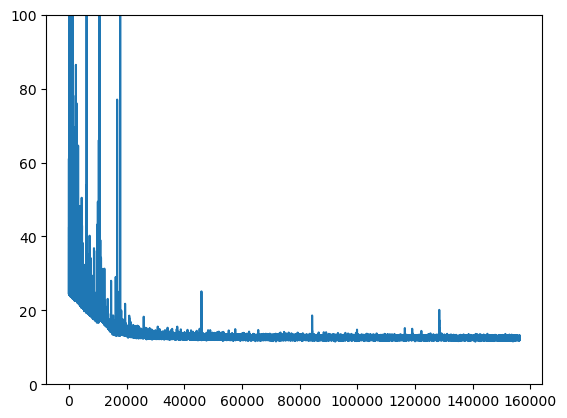

In [146]:
plt.plot(range(1, 156300), losses[:156299])
plt.ylim(0, 100)

# Checking

In [147]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    bins = np.linspace(x_lim[0], x_lim[1], 51)
    
    t_hist = axs[0].hist(truth, bins = bins, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = bins, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

## MC

In [148]:
n, d = sim.shape
sim_smp = flow.sample(n).detach().numpy()

In [149]:
experiment = 'meep'

### Histograms

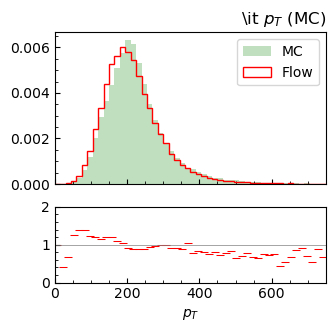

In [150]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../../plots/zenodo/flows/{}/pT_mc.png'.format(experiment)
          )

/tmp/ipykernel_28852/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


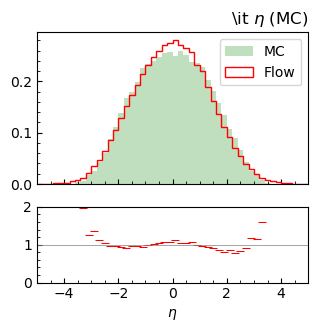

In [151]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../../plots/zenodo/flows/{}/eta_mc.png'.format(experiment)
          )

/tmp/ipykernel_28852/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


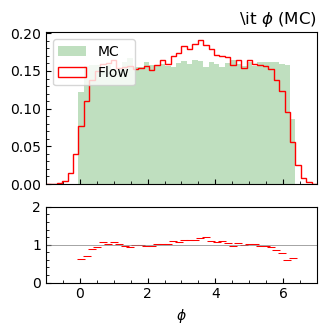

In [152]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../../plots/zenodo/flows/{}/phi_mc.png'.format(experiment)
          )

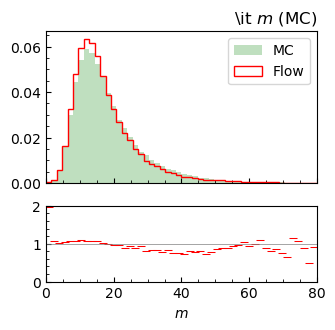

In [153]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../../plots/zenodo/flows/{}/m_mc.png'.format(experiment)
          )

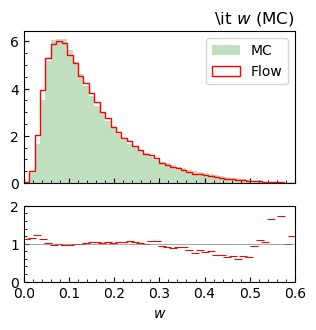

In [154]:
ratio_hist(sim[:, 4], sim_smp[:, 4], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../../plots/zenodo/flows/{}/w_mc.png'.format(experiment)
          )

/tmp/ipykernel_28852/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


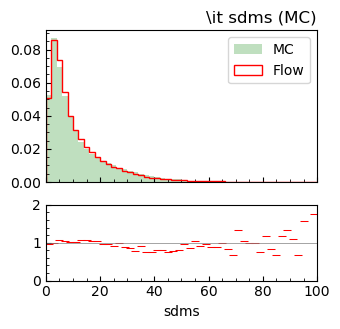

In [155]:
ratio_hist(sim[:, 5], sim_smp[:, 5], 
           labels = ['MC', 'Flow', r'sdms'],
           color = 'green',
           figsize = (w, h),
           title = r'\it sdms (MC)',
           x_lim = (0, 100),
           filename = '../../plots/zenodo/flows/{}/sdms_mc.png'.format(experiment)
          )

### Classification

In [156]:
X_bkgd = sim_smp
X_sgnl = sim

In [157]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

#data, m, s = split_data(X_trn, y_trn)

In [158]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

AdaBoostClassifier()

In [159]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

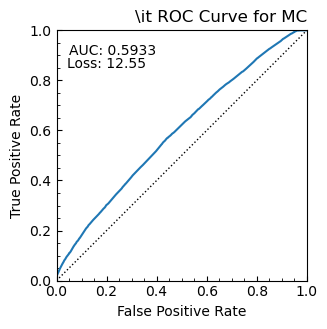

In [163]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for MC', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 4)))
plt.text(0.04, 0.85, 'Loss: {}'.format(round(losses[156299], 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../../plots/zenodo/flows/{}/mc_roc.png'.format(experiment), dpi = 300, transparent = True,
            bbox_inches = 'tight')

# Other

In [61]:
num_layers = 5
base_dist = StandardNormal(shape=[6])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [62]:
num_iter = 5000
losses = np.zeros(num_iter)
for i in range(num_iter):
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=data).mean()
    losses[i] = loss
    
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(i, '\t', round(losses[i], 2))

0 	 74594148352.0
100 	 489.38
200 	 45.3
300 	 32.12
400 	 27.87
500 	 25.9
600 	 24.74
700 	 23.96
800 	 23.38
900 	 22.91
1000 	 22.49
1100 	 22.11
1200 	 21.74
1300 	 21.38
1400 	 21.02
1500 	 20.67
1600 	 20.32
1700 	 20.0
1800 	 19.69
1900 	 19.42
2000 	 19.17
2100 	 18.96
2200 	 18.78
2300 	 18.62
2400 	 18.48
2500 	 18.36
2600 	 18.25
2700 	 18.15
2800 	 18.06
2900 	 17.97
3000 	 17.89
3100 	 17.81
3200 	 17.72
3300 	 17.64
3400 	 17.56
3500 	 17.48
3600 	 17.4
3700 	 17.33
3800 	 17.26
3900 	 17.19
4000 	 17.12
4100 	 17.06
4200 	 16.99
4300 	 16.93
4400 	 16.87
4500 	 16.8
4600 	 16.74
4700 	 16.67
4800 	 16.61
4900 	 16.54


# Visualizing

## Total

In [305]:
loss_0 = np.load('total_0/losses.npy')
min(loss_0[loss_0 > 0])

12.397750854492188

In [306]:
loss_1 = np.load('total_1/losses.npy')
min(loss_1[loss_1 > 0])

12.532134056091309

(12.3, 13.4)

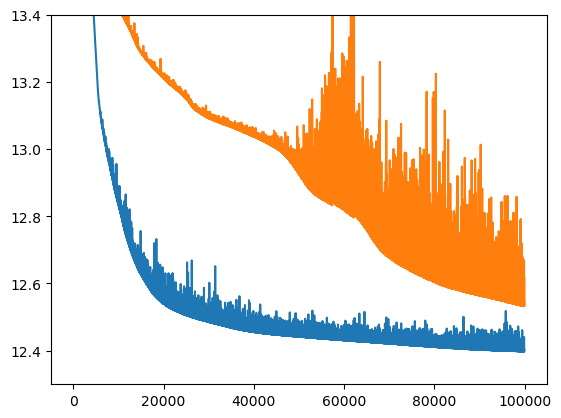

In [307]:
plt.plot(loss_0[loss_0 > 0])
plt.plot(loss_1[loss_1 > 0])
plt.ylim(12.3, 13.4)

## Batches

In [354]:
loss_0 = np.load('batches_0/losses.npy')
min(loss_0[loss_0 > 0])

11.523883819580078

In [355]:
loss_1 = np.load('batches_1/losses.npy')
min(loss_1[loss_1 > 0])

11.440874099731445

(11.2, 15.0)

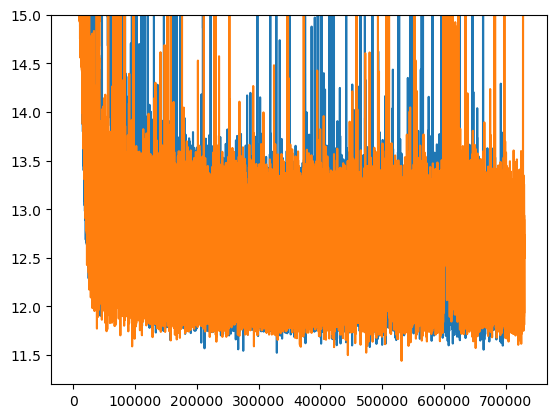

In [356]:
plt.plot(loss_0[loss_0 > 0])
plt.plot(loss_1[loss_1 > 0])
plt.ylim(11.2, 15)